In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [5]:
res = torchvision.models.resnet50(pretrained=True)
for param in res.parameters():
    param.requires_grad=False

model_best = net(base_model=res, base_out_features=res.fc.out_features, num_classes=80)
model_best = model_best.to(device)

model_worst = net(base_model=res, base_out_features=res.fc.out_features, num_classes=80)
model_worst = model_worst.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
model_best.load_state_dict(torch.load('/content/drive/MyDrive/졸업논문/data/model/best_model.pth', map_location=device))
model_best.eval()
model_worst.load_state_dict(torch.load('/content/drive/MyDrive/졸업논문/data/model/worst_model.pth', map_location=device))
model_worst.eval()

In [7]:
!mkdir 'test_cat_img'
!mkdir 'test_dog_img'

In [ ]:
!unzip /content/drive/MyDrive/졸업논문/data/test_case/cat_test.zip -d /content/test_cat_img/
!unzip /content/drive/MyDrive/졸업논문/data/test_case/dog_test.zip -d /content/test_dog_img/

In [10]:
test_cat_list = os.listdir('./test_cat_img')
test_dog_list = os.listdir('./test_dog_img')

In [11]:
dir_cat = './test_cat_img'
dir_dog = './test_dog_img'
test_cat_img = {'img':test_cat_list}
test_cat_img = pd.DataFrame(test_cat_img)
test_cat_img.img = test_cat_img.img.apply(lambda x:dir_cat+'/'+x)
test_dog_img = {'img':test_dog_list}
test_dog_img = pd.DataFrame(test_dog_img)
test_dog_img.img = test_dog_img.img.apply(lambda x:dir_dog+'/'+x)

In [12]:
class setting(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe = dataframe
        self.transform = transform
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0]).convert('RGB')
        x = self.transform(x)
        return x
        
    def __len__(self):
        return self.dataframe.shape[0]

In [13]:
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [14]:
test_cat_dataset = setting(test_cat_img,transform=transformer)
test_cat_loader = DataLoader(test_cat_dataset)

test_dog_dataset = setting(test_dog_img,transform=transformer)
test_dog_loader = DataLoader(test_dog_dataset)

In [15]:
# hash checking

blocks_best = [model_best.base_model,model_best.linear1,model_best.output]
blocks_worst = [model_worst.base_model,model_worst.linear1,model_worst.output]
blocks = blocks_best + blocks_worst
num_blocks_best = len(blocks_best)
num_blocks_worst = len(blocks_worst)

def hash_func(block):
  output = 0
  array = list(block.parameters())
  for i in array:
    j = torch.square(i)
    output += torch.sum(j)
  return output

hash_table = [hash_func(block) for block in blocks]

def hash_check(block,block_num):
  input = hash_func(block)
  if (hash_table[block_num] == input):
    return 0
  else:
    return 1

In [16]:
# Adaptively inject Misinformation
nu = 1000

def softmax(x):
  softmax = torch.nn.Softmax(dim=1)
  return softmax(x)

def reverse_sigmoid(z,nu):
  return 1/(1+torch.exp(nu*z))

def ood_detector(expected_value,tau):
  global nu
  msp = softmax(expected_value)
  max = torch.max(msp)
  return reverse_sigmoid(max-tau,nu)

def AM(f,f_hat,tau):
  alpha = ood_detector(f,tau)
  return (1-alpha)*f + alpha*f_hat


In [17]:
def sim(a,b):
  x = np.array(a) - np.array(b)
  return (len(x)-np.count_nonzero(x))/len(x)

In [18]:
def get_block(block,num):
  return block[num]

def testing(test_loader,tau,num_blocks_best,num_blocks_worst):
  output_original=[]
  output_mislabeled=[]
  check = 1

  for x in test_loader:
    x = x.to(device)
    f = x
    f_hat = x

    for i in range(num_blocks_best):
      block = get_block(blocks_best,i)   # get block from outside of enclave
      if hash_check(block,i) == 1:  # hash check the block
        check = 1
        break          
      else:
        check = 0
        f = block(f)

    for i in range(num_blocks_worst):
      block = get_block(blocks_worst,i)   # get block from outside of enclave
      if hash_check(block,num_blocks_best+i) == 1:  # hash check the block
        check = 1
        break          
      else:
        check = 0
        f_hat = block(f_hat)

    if check == 1:  # When parameters are changed, exit program.
      print("Some parameters are changed. Exit program")
      return 0

    y_hat = AM(f,f_hat,tau)
    _,predicted = torch.max(y_hat.data, 1)
    predicted = predicted.cpu()
    index = predicted.numpy()[0]
    output_mislabeled.append(index)
    _,predicted = torch.max(f.data, 1)
    predicted = predicted.cpu()
    index = predicted.numpy()[0]
    output_original.append(index)
  
  return sim(output_original,output_mislabeled)

In [19]:
tau = np.arange(0.1,1,0.1)
output_cat = []
output_dog = []
for i in tau:
  output_cat.append(testing(test_cat_loader,i,num_blocks_best,num_blocks_worst))
  output_dog.append(testing(test_dog_loader,i,num_blocks_best,num_blocks_worst))

In [20]:
print(output_cat)
print(output_dog)

[1.0, 0.9940652818991098, 0.9277942631058358, 0.7843719090009891, 0.6330365974282888, 0.49554896142433236, 0.3897131552917903, 0.26409495548961426, 0.16122650840751732]
[1.0, 1.0, 0.9821958456973294, 0.9317507418397626, 0.8545994065281899, 0.7388724035608308, 0.6330365974282888, 0.5291790306627102, 0.4085064292779426]


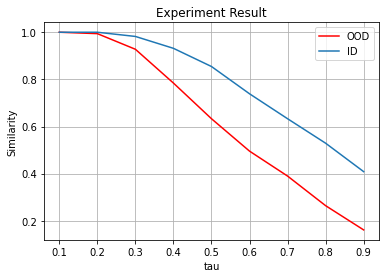

In [21]:
import matplotlib.pyplot as plt

plt.plot(tau,output_cat,'r')
plt.plot(tau,output_dog)
plt.grid(True)
plt.xlabel('tau')
plt.ylabel('Similarity')
plt.title('Experiment Result')
plt.legend(['OOD','ID'])
plt.show()